## NLP Project on Meal chunking

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import re

In [2]:
# importing datasets
meals = pd.read_csv("meals.tsv", sep="\t")
meals_by_row = pd.read_csv("meal_by_row.tsv", sep="\t")

I decided to use Glove vectors to convert the words into their vector representations. The following piece of code creates a dictionary of the words and their embeddings from the file downloaded from Stanford's Glove NLP page.

In [3]:
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        try:
            temp = line.split()
            word = temp[0]
            coefs = np.asarray(temp[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            pass
#             print(line)
f.close()

The following function converts a sentence into its vector representation. I split the sentences on a space. Also, since commas can carry important information here, I included a space before every comma and then split the sentence. So the sentence "Eggs, Sausage and coffee" was converted to "Eggs , Sausage and coffee" which now consists of 5 different elements ["Eggs", ",", "Sausage", "and", "coffee"], each of which are converted to their vector representations.

In [4]:
# this function creates a vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = re.sub(r'(?=[.,])(?=[^\s^])', r' ', words)
    words = words.split()
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            # if the word is not found, I just append a vector of 0's
            M.append(np.zeros(300))
    M = np.array(M)
    return words, M

In [5]:
# creating columns for words and their vectors
meals["words"] = [sent2vec(i)[0] for i in meals["text"]]
meals["vector"] = [sent2vec(i)[1] for i in meals["text"]]

In [6]:
meals["vector"][0].shape

(7, 300)

In [7]:
# converting a sentence into a sequence of numbers
# if a chunk is a single word, it is denoted with 4
# if a chunk has more than one word, the start word is denoted with 2
# and the end word is denoted with 3
def sent2seq(ix):
    sentence_part = meals[meals["idmealjsons"] == ix]["words"]
    items_part = meals_by_row[meals_by_row["mealjson_id"] == ix]["text"].values
    start_points = []
    end_points = []
    single_points = []
    if len(meals[meals["idmealjsons"] == i]) > 0:
        for j in items_part:
            words = str(j).lower()#.decode('utf-8')
            words = re.sub(r'(?=[.,])(?=[^\s^])', r' ', words)
            words = words.split()
            if len(words) > 1:
                start_point = words[0]
                end_point  = words[-1]
                start_points.append(start_point)
                end_points.append(end_point)
            else:
                single_points.append(words[0])
        output = np.zeros(len(list(sentence_part)[0]))
        # start points
        boolean_start = [i in start_points for i in list(sentence_part)[0]]
        output[boolean_start] = 2
        boolean_end = [i in end_points for i in list(sentence_part)[0]]
        output[boolean_end] = 3
        boolean_single = [i in single_points for i in list(sentence_part)[0]]
        output[boolean_single] = 4
        return output

In [8]:
meals_output = []
for i in range(1, meals["idmealjsons"].max()+1):
    meals_output.append((i,sent2seq(i)))
output_df = pd.DataFrame(meals_output, columns = ["id", "output"])

In [9]:
# merging the 2 datasets
meals_combined = pd.merge(meals, output_df, left_on="idmealjsons", right_on="id", how="left")
vector_output = meals_combined[["idmealjsons","vector","output"]]
# checking if the length of the vector is the same as the output
sum(sum([vector_output["vector"].apply(len) != vector_output["output"].apply(len)]))

0

In [10]:
# going to only consider vectors with length 12
np.percentile(vector_output["vector"].apply(len), q = 95)

12.0

In [11]:
len(vector_output[vector_output["vector"].apply(len) < 12])

5618

In [12]:
vector_output_12 = vector_output[vector_output["vector"].apply(len) < 12]

In [13]:
vector_output_12.head()

,idmealjsons,vector,output
0,1,"[[-0.41781, -0.035192, -0.12615, -0.21593, -0....","[4.0, 0.0, 4.0, 0.0, 4.0, 0.0, 4.0]"
1,2,"[[-0.37412, -0.076264, 0.10926, 0.18662, 0.029...","[2.0, 3.0, 0.0, 4.0, 0.0, 4.0, 0.0, 2.0, 3.0]"
2,3,"[[-0.48838, 0.095686, 0.71593, -0.28175, 0.016...","[4.0, 0.0, 4.0, 0.0, 4.0]"
3,4,"[[-0.3449, -0.51021, 0.25005, -0.74105, 0.1379...","[2.0, 3.0]"
4,5,"[[-0.64583, -0.41343, 0.71445, 0.55511, 0.1908...","[4.0, 0.0, 4.0, 0.0, 4.0]"


In [14]:
# padding with 0's on the right
list_extras = 12 - vector_output_12["vector"].apply(len)
vector_output_12["pad_right"] = [np.ones((i, 300)) for i in list_extras]
vector_output_12["y_pad_right"] = [np.ones(i) for i in list_extras]

vector_output_12["padded_vector"] = [np.concatenate(i) for i in np.hstack((vector_output_12[["vector"]], vector_output_12[["pad_right"]]))]
vector_output_12["padded_output"] = [np.concatenate(i) for i in np.hstack((vector_output_12[["output"]], vector_output_12[["y_pad_right"]]))]

C:\Users\mansiarora\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mansiarora\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\mansiarora\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [15]:
# creating the final datasets with 12 timesteps, 300 features
final = vector_output_12[["padded_vector", "padded_output"]]
X = np.array([np.concatenate(i) for i in final["padded_vector"]]).reshape(len(final), 12, 300)
y = np.array([i for i in final["padded_output"]]).reshape(len(final), 12)
print(X.shape)
print(y.shape)

(5618, 12, 300)
(5618, 12)


In [16]:
# deciding length of validation set (has to be a multiple of 32 i.e. the batch size)
int(len(X)*0.1/32)*32

544

In [17]:
# deciding the length of training set
int(((len(X) - 1088)/32))*32

4512

In [18]:
# converting y to categorical
from keras.utils import to_categorical
y = np.array([to_categorical(i, num_classes=5) for i in y])

C:\Users\mansiarora\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
y.shape

(5618, 12, 5)

In [20]:
X_train = X[0:4512]
X_val = X[4512:4512+544]
X_test = X[4512+544:4512+544+544]
y_train = y[0:4512]
y_val = y[4512:4512+544]
y_test = y[4512+544:4512+544+544]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4512, 12, 300)
(544, 12, 300)
(544, 12, 300)
(4512, 12, 5)
(544, 12, 5)
(544, 12, 5)


Chose LSTMs because this is a sequence problem, where the history of the words matters to decide when to start and stop the subsequence

In [21]:
# Model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, TimeDistributed
from keras.layers.core import Dense
from keras import optimizers
model = Sequential()
model.add(LSTM(30, batch_input_shape = (32, 12, 300), return_sequences=True))
model.add(TimeDistributed(Dense(5, activation="softmax"))) # softmax output layer
adam = optimizers.Adam(0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (32, 12, 30)              39720     
_________________________________________________________________
time_distributed_1 (TimeDist (32, 12, 5)               155       
Total params: 39,875
Trainable params: 39,875
Non-trainable params: 0
_________________________________________________________________


In [22]:
val_loss = []
loss = []
history = model.fit(X_train, y_train, shuffle=True,
                    epochs = 50, batch_size=32, validation_data = (X_val, y_val), verbose=0)

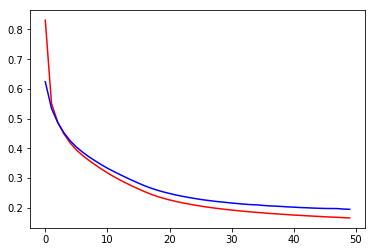

In [23]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], color="red")
plt.plot(history.history['val_loss'], color = "blue")
plt.show()

In [24]:
y_pred = model.predict(X_test)

In [25]:
# Results 
# 2 means start the chunk, 3 means end the chunk, 4 means it's a single word
meal_ids = vector_output_12[4512+544:4512+544+544]["idmealjsons"]
meals_test = pd.DataFrame(meals[meals["idmealjsons"].isin(meal_ids)]["words"]).reset_index(drop=True)
actual_pred = pd.DataFrame([(np.argmax(y_pred[i], axis=1),np.argmax(y_test[i], axis=1)) for i in range(len(y_pred))], columns = ["Predicted", "Actual"])
pd.concat((actual_pred, meals_test), axis=1)[["Predicted", "Actual"]]

,Predicted,Actual
0,"[4, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,"[4, 0, 4, 0, 4, 0, 2, 1, 1, 1, 1, 1]","[4, 0, 4, 0, 4, 0, 4, 1, 1, 1, 1, 1]"
2,"[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,"[4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 0, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1]"
4,"[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
5,"[4, 0, 3, 0, 4, 1, 1, 1, 1, 1, 1, 1]","[2, 0, 3, 0, 4, 1, 1, 1, 1, 1, 1, 1]"
6,"[4, 0, 3, 0, 4, 0, 4, 0, 4, 1, 1, 1]","[2, 0, 3, 0, 4, 0, 4, 0, 4, 1, 1, 1]"
7,"[4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
8,"[2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
9,"[4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


As we can see, by scrolling of the examples, the model is able to accurately detect when to start and stop the chunks.